## Implementating Kendall Tau
- Plus testing

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def test(F_lim, z_i):
    return F_lim*z_i

def L_lim1(F_lim, z_i):
    return (8e26/0.15)*F_lim*z_i**2.4

def sort_by_first(A, B): #SORT USING Z!
    list1, list2 = zip(*sorted(zip(A, B)))
    return list(list1), list(list2)

def kendall_tau(L, z, F_lim, srted=False, func=L_lim1):
    
    #if necessary, sort by z while keeping reference to L
    if not srted:
        z, L = sort_by_first(z, L)
        
    R = []
    E = []
    V = []
    
    for i in range(len(L)):
        higher = 0
        lower = 0
        
        for j in range(0, i): #since sorted by now, only j < i has z_j < z_i
            if(L[j] >= func(F_lim, z[i]) and z[j] <= z[i]): #associated set requirements
                if(L[j] > L[i]):
                    higher += 1
                else:
                    lower += 1
        
        R.append((lower+1)/(higher+lower+1))
        E.append(0.5)
        V.append(1/12)
    
    numer = sum(R) - sum(E)
    denom = (sum(V))**0.5
    return numer/denom

In [2]:
#SETTING UP TEST

np.random.seed(0)

z = np.random.uniform(0,1,1000)
L = np.random.uniform(0,1,1000)

F_lim = 0.5

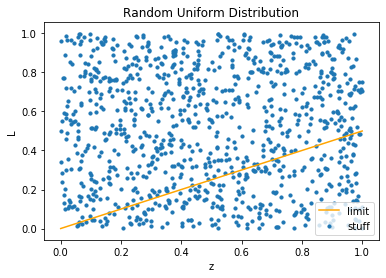

In [3]:
fig, ax = plt.subplots() 
ax.scatter(z, L, label='stuff', s=10)
ax.plot(np.sort(z), test(F_lim, np.sort(z)), label='limit', color = 'orange')
ax.set_xlabel('z')  # Add an x-label to the axes.
ax.set_ylabel('L')  # Add a y-label to the axes.

ax.set_title("Random Uniform Distribution")  # Add a title to the axes.
ax.legend()  # Add a legend.
plt.show()

In [4]:
#cleaning up observations that wouldn't actually be seen

def obs_cleanup(L, z, func=L_lim1):

    z = list(z)
    L = list(L)

    for i in reversed(range(len(z))): #reversed so when deleting, doesn't mess up indices
        if(L[i] < func(F_lim, z[i])):
            del z[i]
            del L[i]
    
    return L, z

In [5]:
L, z = obs_cleanup(L, z, func=test)

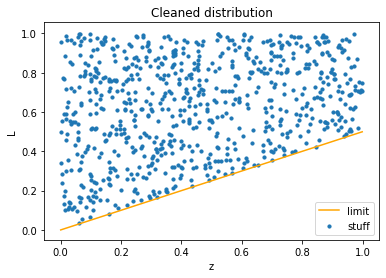

In [6]:
#Plotting the Cleaned Up Data

fig, ax = plt.subplots() 
ax.scatter(z, L, label='stuff', s=10)
ax.plot(np.sort(z), test(F_lim, np.sort(z)), label='limit', color = 'orange')
ax.set_xlabel('z')
ax.set_ylabel('L')

ax.set_title("Cleaned distribution")
ax.legend()
plt.show()

In [7]:
#now sorting

z, L = sort_by_first(z, L)

In [8]:
#applying Kendall Tau

kendall_tau(L, z, F_lim, srted=True, func=test)

0.4786956817782335

## Applying Kendall Tau in Actual FRB Data

In [12]:
import csv

frb, telescope, snr, f_p, d_L, z = [], [], [], [], [], []

with open('frb.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            line_count += 1
            if float(row[2]) > 5:
                frb.append(row[0])
                telescope.append(row[1])
                snr.append(float(row[2]))
                f_p.append(float(row[3]))
                d_L.append(float(row[4]))
                z.append(float(row[5]))
    print(f'Processed {line_count} lines.')

Column names are FRB, Telescope, S/N ratio, Peak Flux (Jy), Luminosity Distance (Gpc), Redshift (inferred), Peak Flux Limit (Jy), Peak Luminosity (W), Limiting Luminosity (W)
Processed 64 lines.


In [13]:
import math
import matplotlib.pyplot as plt

#Deriving New Parameters
f_lim = []
L_p = []
L_plim = []

for i in range(len(f_p)):
    f_lim_i = f_p[i]/(snr[i])
    L_p_i = (f_p[i]*1e-26)*4*math.pi*(d_L[i]*3.08567758e25)**2
    L_plim_i = (f_lim_i*1e-26)*4*math.pi*(d_L[i]*3.08567758e25)**2
    f_lim.append(f_lim_i)
    L_p.append(L_p_i)
    L_plim.append(L_plim_i)

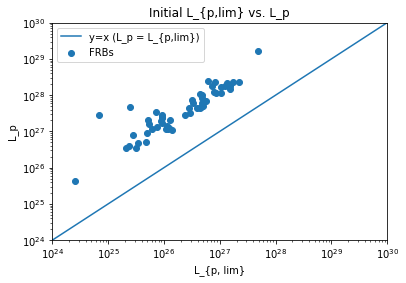

In [14]:
#Plotting L_p versus L_{p, lim}

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
ax.scatter(L_plim, L_p, label='FRBs')
ax.plot([1e20, 1e32], [1e20, 1e32], label='y=x (L_p = L_{p,lim})')
ax.set_xlim([1e24, 1e30])
ax.set_ylim([1e24, 1e30])
ax.set_xlabel('L_{p, lim}')
ax.set_ylabel('L_p')
ax.set_title('Initial L_{p,lim} vs. L_p')
ax.legend()

plt.show()

### Using Kendall Tau Here

In [15]:
#That's not the graph we'll be using for this next part though.
#We'll be using the L versus z graph first


## Determining Limiting Flux

F_cut = 0.15 # in Jy

#x values are z
#y values are corresponding L's compared to F_lim
d_L_sorted = sorted(d_L)
L_cutoff =[(F_cut*1e-26)*4*math.pi*(d_L_sorted[i]*3.08567758e25)**2 for i in range(len(z))]
z_sorted = sorted(z)

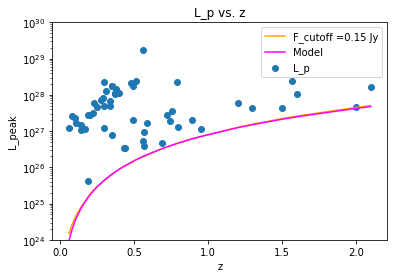

In [16]:
#The GRAPH
fig, ax = plt.subplots()
plt.yscale('log')
ax.scatter(z, L_p, label='L_p')
ax.plot(z_sorted, L_cutoff, label='F_cutoff =' +str(F_cut)+ ' Jy', color='orange')
ax.plot(z_sorted, L_lim1(F_cut, np.array(z_sorted)), label = 'Model', color='magenta')
ax.set_ylim([1e24, 1e30])
ax.set_xlabel('z')
ax.set_ylabel('L_peak')
ax.set_title('L_p vs. z')
ax.legend()

In [17]:
z_, L_p_ = sort_by_first(z, L_p)

In [18]:
#Initial Kendall Tau
kt = kendall_tau(L_p_, z_, F_cut, srted=True)
print(kt)

2.5376650934120386


### Implementing Range of k

In [22]:
#creating L' given original L, z, and k
#L' = L*g(z) = L*(1+z)^k

NEW = False

def g(z, k):
    if NEW:
        Z = z+1
        Z_c = 3.5
        return Z**k/(1+Z/Z_c)**k
    return (1+z)**k

def new_L(L, z, k):
    return [L[i]/g(z[i], k) for i in range(len(L))]

#finding tau given a value of k

def tau_k(L_p, z, k, F_lim, func=L_lim1):
    L_new = new_L(L_p, z, k)
    return kendall_tau(L_new, z, F_lim, func=func)

In [23]:
#plot tau for multiple values of k
k_min = 0
k_max = 5
dk = 0.01

#the current k value
k = k_min

#list of k, tau
list_k = []
list_t = []

k1 = k_min #k closest to tau = 1
kn1 = k_min #k closest to tau = -1

dif1 = 1e300 #smallest distance so far to tau = 1
difn1 = 1e300 #smallest distance so far to tau = -1

while(k <= k_max):
    list_k.append(k)
    t_k = tau_k(L_p, z, k, F_cut)
    list_t.append(t_k)
    
    if(abs(t_k-1) < dif1):
        dif1 = abs(t_k-1)
        k1 = k
    if(abs(t_k+1) < difn1):
        difn1 = abs(t_k+1)
        kn1 = k
    
    k += dk

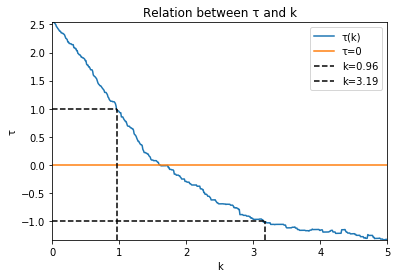

In [24]:
YMAX, YMIN = max(list_t), min(list_t)
XMAX, XMIN = k_max, k_min
MAR = 0 #margin

fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(list_k, list_t, label='τ(k)')
ax.plot(list_k, [0 for i in range(len(list_k))], label='τ=0')
ax.plot([k1 for i in range(11)], [YMIN+(1-YMIN)*i/10 for i in range(11)], color='black', linestyle='--', label='k=0.96')
ax.plot([kn1 for i in range(11)], [YMIN+(-1-YMIN)*i/10 for i in range(11)], color='black', linestyle='--', label='k=3.19')
ax.plot([XMIN + (k1-XMIN)*i/10 for i in range(11)],[1 for i in range(11)], color='black', linestyle='--')
ax.plot([XMIN + (kn1-XMIN)*i/10 for i in range(11)],[-1 for i in range(11)], color='black', linestyle='--')
ax.set_ylim([YMIN-MAR, YMAX+MAR])
ax.set_xlim([XMIN-MAR, XMAX+MAR])
ax.set_xlabel('k')  # Add an x-label to the axes.
ax.set_ylabel('τ')  # Add a y-label to the axes.
ax.plot()

ax.set_title("Relation between τ and k")  # Add a title to the axes.
ax.legend()  # Add a legend.

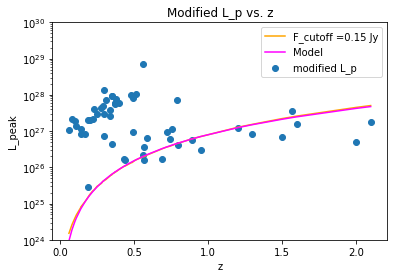

In [20]:
nL = new_L(L_p, z, -2)
fig, ax = plt.subplots()
plt.yscale('log')
ax.scatter(z, nL, label='modified L_p')
ax.plot(z_sorted, L_cutoff, label='F_cutoff =' +str(F_cut)+ ' Jy', color='orange')
ax.plot(z_sorted, L_lim1(F_cut, np.array(z_sorted)), label = 'Model', color='magenta')
ax.set_ylim([1e24, 1e30])
ax.set_xlabel('z')
ax.set_ylabel('L_peak')
ax.set_title('Modified L_p vs. z')
ax.legend()

### Implementing for L_p versus L_{p,lim}

In [21]:
old_Llim = L_plim
#whenever we're using the original, use old_Llim

In [22]:
#First, we need an adjustable method to switch between different methods and different X

X = 10
method = False #False = (S/N-X), True = X/(S/N)

def set_to_one(x):
    return (x if x >= 1 else 1)

In [23]:
if not method: # (S/N - X)
    L_plim = [old_Llim[i] * snr[i]/set_to_one(snr[i]-X) for i in range(len(old_Llim))]
else: # X/(S/N)
    L_plim = [old_Llim[i] * X for i in range(len(old_Llim))]

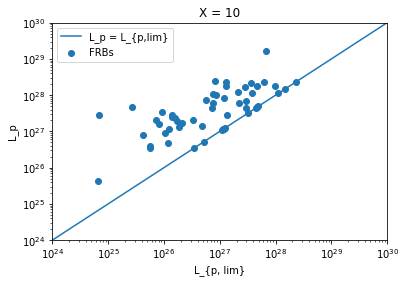

In [24]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
ax.scatter(L_plim, L_p, label='FRBs')
ax.plot([1e20, 1e32], [1e20, 1e32], label='L_p = L_{p,lim}')
ax.set_xlim([1e24, 1e30])
ax.set_ylim([1e24, 1e30])
ax.set_xlabel('L_{p, lim}')
ax.set_ylabel('L_p')
ax.set_title('X = ' + str(X))
ax.legend()

plt.show()

In [25]:
def L_lim2(F_cut, L_plim): #Defining a new L_lim function
    return L_plim

In [ ]:
L_plim, L_p = sort_by_first(L_plim, L_p) #sort by x

In [ ]:
#Initial Kendall Tau
kt = kendall_tau(L_p, L_plim, F_cut, func=L_lim2) #Note: F_cut no longer matters
print(kt)

In [ ]:
#plot tau for multiple values of k
k_min = -1
k_max = 1
dk = 0.001

#the current k value
k = k_min

#list of k, tau
list_k = []
list_t = []

while(k <= k_max):
    list_k.append(k)
    list_t.append(tau_k(L_p, L_plim, k, F_cut, func=L_lim2))
    k += dk

In [ ]:
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(list_k, list_t, label='τ(k)')
ax.plot(list_k, [0 for i in range(len(list_k))], label='τ=0')
ax.set_xlabel('k')  # Add an x-label to the axes.
ax.set_ylabel('τ')  # Add a y-label to the axes.

ax.set_title("Relation between τ and k")  # Add a title to the axes.
ax.legend()  # Add a legend.

In [ ]:
news = new_L(L_p, L_plim, -0.017)

In [ ]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
ax.scatter(L_plim, news, label='using k = -0.017')
ax.plot([1e20, 1e32], [1e20, 1e32], label='L_p = L_{p,lim}')
ax.set_xlim([1e24, 1e30])
ax.set_ylim([1e24, 1e30])
ax.set_xlabel('L_{p, lim}')
ax.set_ylabel('L_p')
ax.set_title('X = ' + str(X))
ax.legend()

plt.show()